In [1]:
#### Images
from matplotlib.pyplot import imread
from scipy.misc import toimage
import cv2 as cv
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks, rotate
from PIL import Image
from skimage import filters

#### Graph
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.path as mplPath

#### Strings
from StringIO import StringIO
from fuzzywuzzy import fuzz, process
import re
from textblob import TextBlob, Word
import difflib
import editdistance
import re

#### Data
import pandas as pd
import numpy as np
import pytesseract

#### Misc
import multiprocessing
from multiprocessing import Pool
from pprint import pprint
import os
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from collections import Counter

tqdm_notebook.pandas()

%matplotlib inline

/home/localhost/Desktop/Projects/Working/Autism/venv/local/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Multiprocessing Apply

In [3]:
def _apply_df(args):
    df, func, kwargs = args
    return df.progress_apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

### Load images

In [4]:
test_image = './peabody_files/Accession Files/110/110_8348.pdf.png'
root = './peabody_files/Accession Files/'
accessions = filter(lambda x: x != ".DS_Store", os.listdir(root))
paths = []
errors = {}
for acc in tqdm(accessions):
    acc_path = root+acc
    acc_images = filter(lambda x: x != ".DS_Store", os.listdir(acc_path))
    for image in tqdm(acc_images, leave=False):
        img_path = acc_path+'/'+image
        paths.append(img_path)
print('Loaded', len(paths), "image paths")

HBox(children=(IntProgress(value=0, max=108), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=94), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=13), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1923), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=116), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=996), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=929), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=141), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=217), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=112), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=40), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=130), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=455), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=358), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=58), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=45), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=424), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1646), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=14), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=15), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=69), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=18), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=40), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=64), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=56), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=22), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=35), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=154), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=38), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=526), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=66), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=46), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=48), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=721), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=125), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=11), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=457), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=77), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=34), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=664), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=64), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=63), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=46), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=23), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=357), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=43), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=14), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=213), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=198), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=99), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=19), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=476), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=199), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=38), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=25), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=44), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=53), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=363), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=13), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=315), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=63), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=13), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=123), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=149), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=36), HTML(value=u'')))


('Loaded', 14497, 'image paths')


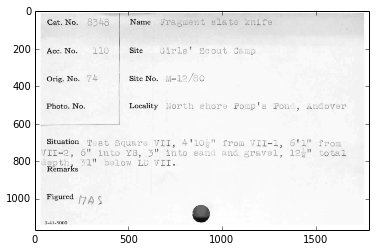

In [5]:
def load_image(path):
    img = imread(path)
    if len(img.shape) != 2:
        img = cv.cvtColor(img, cv.COLOR_BGRA2GRAY) # Convert color space
    if np.max(img) <= 1.1:
        img *= 255
    img = img.astype('uint8')
    return img
image = load_image(test_image)
imshow(image, cmap='gray')

### Binarization

In [6]:
def binarize(img):
    return cv.threshold(cv.GaussianBlur(img,(5,5),0),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

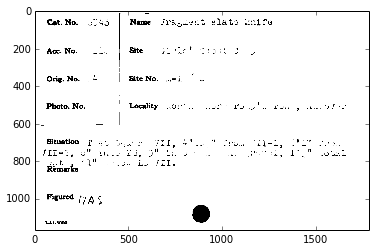

In [7]:
imshow(binarize(image), cmap='gray')

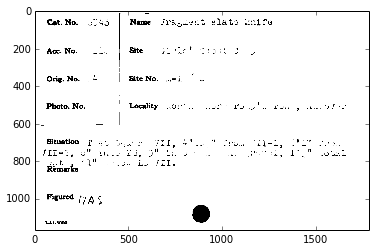

In [8]:
image = binarize(image)
imshow(image, cmap='gray')

### Noise Removal


In [9]:
def remove_noise(img):
    return cv.fastNlMeansDenoising(img)

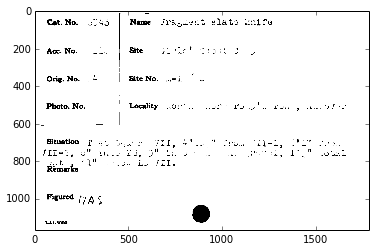

In [10]:
image = remove_noise(image)
imshow(image, cmap='gray')

### Rotation / Deskewing
##### Creds to https://github.com/kakul/Alyn/blob/master/alyn/skew_detect.py

In [11]:
def deskew(img):
    #### Estimate Angle
    piby4 = np.pi / 4
    def get_max_freq_elem(arr):
        max_arr = []
        freqs = {}
        for i in arr:
            if i in freqs:
                freqs[i] += 1
            else:
                freqs[i] = 1
        sorted_keys = sorted(freqs, key=freqs.get, reverse=True)
        max_freq = freqs[sorted_keys[0]]
        for k in sorted_keys:
            if freqs[k] == max_freq:
                max_arr.append(k)
        return max_arr

    def calculate_deviation(angle):
        angle_in_degrees = np.abs(angle)
        deviation = np.abs(piby4 - angle_in_degrees)
        return deviation
    compare_sum = lambda x: x>=44 and x <=46

    edges = canny(img, sigma=3)
    h, a, d = hough_line(edges)
    _, ap, _ = hough_line_peaks(h, a, d, num_peaks=20)

    if len(ap) == 0:
        raise ValueError("BAD IMAGE")

    absolute_deviations = [calculate_deviation(k) for k in ap]
    average_deviation = np.mean(np.rad2deg(absolute_deviations))
    ap_deg = [np.rad2deg(x) for x in ap]

    bin_0_45 = []
    bin_45_90 = []
    bin_0_45n = []
    bin_45_90n = []

    for ang in ap_deg:
        deviation_sum = int(90 - ang + average_deviation)
        if compare_sum(deviation_sum):
            bin_45_90.append(ang)
            continue
        deviation_sum = int(ang + average_deviation)
        if compare_sum(deviation_sum):
            bin_0_45.append(ang)
            continue
        deviation_sum = int(-ang + average_deviation)
        if compare_sum(deviation_sum):
            bin_0_45n.append(ang)
            continue
        deviation_sum = int(90 + ang + average_deviation)
        if compare_sum(deviation_sum):
            bin_45_90n.append(ang)
    angles = [bin_0_45, bin_45_90, bin_0_45n, bin_45_90n]
    lmax = 0
    for j in range(len(angles)):
        l = len(angles[j])
        if l > lmax:
            lmax = l
            maxi = j
    if lmax:
        ans_arr = get_max_freq_elem(angles[maxi])
        ans_res = np.mean(ans_arr)

    else:
        ans_arr = get_max_freq_elem(ap_deg)
        ans_res = np.mean(ans_arr)
    #### Rotate Image
    angle = ans_res
    if angle <= 30:
        return img
    if angle >= 0 and angle <= 90:
        rot_angle = angle - 90
    if angle >= -45 and angle < 0:
        rot_angle = angle - 90
    if angle >= -90 and angle < -45:
        rot_angle = 90 + angle

    rotated = rotate(img, rot_angle, resize=True, clip=True, mode='edge')
    return rotated

In [12]:
def crop_image(img,tol=.999):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

In [13]:
image = crop_image(deskew(image))

### Mean Image

In [14]:
##### This is used to get the rough coordinates below

# shape = (int(np.mean([x.shape[1] for x in images])), int(np.mean([x.shape[0] for x in images]))) # Calculate mean shape
# arr = np.zeros((shape[1], shape[0]))
# count = 0
# sample_count = 0 # Only take so many from each acc.
# sampling = 10
# errors = {}
# for acc in tqdm(accessions):
#     acc_path = root+acc
#     acc_images = filter(lambda x: x != ".DS_Store", os.listdir(acc_path))
#     for image in tqdm(acc_images, leave=False):
#         img_path = acc_path+'/'+image
#         try:
#             img = load_image(img_path)
#             img = binarize(img)
#             img = remove_noise(img)
#             img = deskew(img)
#             arr += cv.resize(img, shape)
#             count += 1
#         except Exception as e:
#             errors[img_path] = e
#         sample_count += 1
    
#         if sample_count >= sampling:
#             sample_count = 0
#             break
#     imshow(arr/count, cmap='gray')
#     plt.show()
# np.savez('mean_image', arr/count)

In [15]:
# # Load image
# image = np.load('mean_image.npz')
# image = image[image.keys()[0]]
# # Create axis
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.imshow(image, cmap='gray')

# coords = []

# def onclick(event):
#     global ix, iy
#     ix, iy = event.xdata, event.ydata
#     print('(%d, %d),'%(ix, iy))
#     global coords
#     coords.append((ix, iy))
#     return coords

# cid = fig.canvas.mpl_connect('button_press_event', onclick)

### OCR

In [16]:
def to_boxes(img):
    img = Image.fromarray(img)
    txt = pytesseract.image_to_data(img, config='-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-()./\\\'')
    df = pd.read_csv(StringIO(txt), sep='\t')
    df = df.dropna()
    return df
df = to_boxes(image)

### DF Processing

In [17]:
# (Upper Left, Lower left, Lower Right, Upper Right) Gotten from mean_image script
info_rough_locations = {'CatNo': mplPath.Path([(35, 32), (43, 86), (394, 83), (392, 29)]),
                        'AccNo': mplPath.Path([(26, 182), (32, 246), (386, 246), (378, 148)]),
                        'OrigNo': mplPath.Path([(34, 327), (37, 388), (396, 394), (396, 317)]),
                        'PhotoNo': mplPath.Path([(30, 467), (32, 536), (407, 528), (407, 458)]),
                        'Situation': mplPath.Path([(42, 642), (45, 801), (1781, 818), (1774, 642)]),
                        'Remarks': mplPath.Path([(21, 793), (39, 926), (1752, 969), (1741, 775)]),
                        'Figured': mplPath.Path([(24, 936), (35, 1033), (1731, 1062), (1724, 972)]),
                        'Name': mplPath.Path([(466, 6), (470, 103), (1727, 114), (1716, 6)]),
                        'Site': mplPath.Path([(462, 153), (473, 254), (1576, 257), (1540, 121)]),
                        'SiteNo': mplPath.Path([(470, 301), (477, 401), (1188, 408), (1152, 272)]),
                        'Locality': mplPath.Path([(462, 444), (477, 602), (1724, 617), (1727, 419)])}

f_to_acc = {'CatNo': 'Cat. No.',
            'AccNo': 'Acc. No.',
            'OrigNo': 'Orig. No.',
            'PhotoNo': 'Photo No.',
            'SiteNo': 'Site No.'}
conv = lambda x: x if x not in f_to_acc.keys() else f_to_acc[x]

In [18]:
class SectionProcess(object):
    @staticmethod
    def _fuzzy_crop(key, s, preceding=False):

        n = len(key.split())
        arr = s.split()
        pairs = [' '.join([arr[i2+i] for i2 in range(0,n)]) for i in range(0, len(arr)-n+1)]
        pairs = process.extract(key, pairs, scorer=fuzz.token_sort_ratio)
        pairs = filter(lambda x: x[1] > 50, pairs)
        if len(pairs) == 0: ## No matches
            if preceding:
                return s
            return s
        pair = max(pairs, key=lambda x:x[1])[0]
        try:
            idx = s.index(pair)
        except:
            if preceding:
                return s
            return s
        if preceding:
            return s[:idx]
        else:
            return s[idx+len(pair):]
        

    @staticmethod
    def fuzzy_crop(keys, s, preceding=False):
        '''
        Fuzzily crops the nearest string. 
        If preceding is true, it takes what is prior to that string,
        otherwise what is after.
        '''
        if type(keys) is str:
            keys = [keys]
        for key in keys:
            s = SectionProcess._fuzzy_crop(key, s, preceding)
        return s
    
    @staticmethod
    def grab_next(s):
        a = s.split()
        if len(a) == 0:
            return s
        return a[0]
    
    @staticmethod
    def CatNo(s):
        s = SectionProcess.fuzzy_crop('Name', s, preceding=True)
        return SectionProcess.grab_next(s)
    
    @staticmethod
    def AccNo(s):
        return SectionProcess.grab_next(s)
    
#     @staticmethod
#     def Name(s):
#         return SectionProcess.fuzzy_crop(['Acc. No.', 'Acc.No.', 'Site'], s, preceding=True)
    
#     @staticmethod
#     def OrigNo(s):
#         return SectionProcess.fuzzy_crop(['Site No.', 'SiteNo.', 'Photo.'], s, preceding=True)
    
#     @staticmethod
#     def Site(s):
#         return SectionProcess.fuzzy_crop(['Orig No.', 'Orig No.'], s, preceding=True)

#     @staticmethod
#     def SiteNo(s):
#         s = SectionProcess.fuzzy_crop('Locality', s)
#         return SectionProcess.fuzzy_crop(['Photo. No.', 'Photo.No.'], s, preceding=True)
    
#     @staticmethod
#     def PhotoNo(s):
#         return SectionProcess.fuzzy_crop('Locality', s, preceding=True)
    
#     @staticmethod
#     def Situation(s):
#         return SectionProcess.fuzzy_crop('Remarks', s, preceding=True)
    
#     @staticmethod
#     def Figured(s):
#         return SectionProcess.fuzzy_crop('Remarks', s, preceding=True)
    
#     @staticmethod
#     def Remarks(s):
#         return SectionProcess.fuzzy_crop('Figured', s, preceding=True)
    
#     @staticmethod
#     def Locality(s):
#         return SectionProcess.fuzzy_crop('Locality', s, preceding=True)
    

In [19]:
def process_boxes(_df):
    ret_dict = {}
    guess = None
    # To-DO: Create array of spans!
    for key in info_rough_locations.keys():
        tmp = _df[_df.apply(lambda x: bool(info_rough_locations[key].contains_point((x['left'] ,x['top']))), axis=1)]
        guess = ' '.join(tmp['text']).strip()
        guess = SectionProcess.fuzzy_crop(conv(key), guess)
        if hasattr(SectionProcess, key):
            guess = getattr(SectionProcess, key)(guess)
        guess = guess.strip()
        ret_dict[key] = guess
    return ret_dict
d = process_boxes(df)

In [20]:
d

{'AccNo': '',
 'CatNo': '',
 'Figured': 'Fwd HAS .',
 'Locality': "0-' u) Bo (L.. J'.' '",
 'Name': "iPaO'u'flLt slats knife",
 'OrigNo': '',
 'PhotoNo': 'Photo.No.',
 'Remarks': 'b I',
 'Site': "JLJLf' 2 km 3",
 'SiteNo': "A-r ' u",
 'Situation': 'III-fh u" Ll.-J IJ  3" l . J M u lJtl. l" - II I'}

### Create Master DataFrame

In [21]:
df = pd.DataFrame(columns=info_rough_locations.keys()+['f_name'])
row = 0
def process_image(img_path):
    global boxes
    d = {}
    try:
        img = load_image(img_path)
        imshow(img, cmap='gray')
        img = binarize(img)
        img = remove_noise(img)
        img = deskew(img)
        boxes = to_boxes(img)
        d = process_boxes(boxes)
        d['AccNo'] = img_path.split('/')[-2]
        d['f_name'] = img_path.split('/')[-1]
        d['CatNo'] = img_path.split('/')[-1].split('_')[1].split('.')[0]
    except Exception as e:
        print("ERROR!")
        print(e)
        print(d)
    return d

n = 100
def append_to_df(d):
    global row, df
    for key in d.keys():
        df.loc[row,key] = d[key]
    row += 1
    # Save every n
    if row % n == 0:
        df.to_csv('april15_transcription.csv')

In [ ]:
# map(lambda x: append_to_df(process_image(x)), tqdm(paths))
# p = Pool(6)
# r = p.map(process_image, tqdm(paths))
# p.close()
# for val in tqdm(p.imap_unordered(process_image, paths), total=len(paths)):
#     append_to_df(val)
# p.close()
paths = sorted(paths)
errors = {}
for path in tqdm(list(paths)):
    if df['f_name'].str.contains(path.split('/')[-1]).any():
        continue
    try:
        append_to_df(process_image(path))
    except Exception as e:
        errors[path] = e
df.to_csv('april15_transcription.csv')

HBox(children=(IntProgress(value=0, max=14497), HTML(value=u'')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/localhost/Desktop/Projects/Working/Autism/venv/local/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/localhost/Desktop/Projects/Working/Autism/venv/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



ERROR!
Error tokenizing data. C error: EOF inside string starting at line 69
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 48
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 43
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 55
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 49
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 68
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 50
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 32
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 8
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 36
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 37
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 18
{}
ERROR!
Error tokenizing data. C error: EO

ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 72
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tos

ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() ha

ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() ha

ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() has been removed. Please call tobytes() instead.
{}
ERROR!
tostring() ha

ERROR!
Error tokenizing data. C error: EOF inside string starting at line 78
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 47
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 79
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 49
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 34
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 55
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 9
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 47
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 60
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 59
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 51
{}
ERROR!
Error tokenizing data. C error: EOF inside string starting at line 63
{}
ERROR!
Error tokenizing data. C error: EO

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocate memory
{}
ERROR!
[Errno 12] Cannot allocat

In [2]:
df = pd.read_csv('april15_transcription.csv', index_col=0).replace(np.NaN, '')
# df.tail()

In [3]:
len(df)

8968

### Correct Site Numbers

In [4]:
### TO-DO: Update in time
# Below is the list of site numbers created
# ids = Counter(list(df['SiteNo']))
# df[df['SiteNo'] == 'SiteNo. 159.152/1']
# pprint(sorted(ids, key=ids.get, reverse=True))

In [5]:
site_nos = ['', 'Me. 152/7', 'Me. 152/1', 'M39/7', 'He. 152/7', 'He. 152/1', 'M39/7', 'He.152/1', 'M12/43', 'M49/31', 'Me.153/7', 'H35', 'M50/1', 'M13/77', 'Me. 158/7', 'Me. 158/1', 'M. 59/63', 'M 50/9']

In [6]:
### Correcting from prelabeled data in test5.csv
### May need to be disabled in future.
df['CatNo'] = pd.to_numeric(df['CatNo'], errors='coerce').fillna(-1).astype(np.int64)
tmp = pd.read_csv('test5.csv')
tmp = tmp[['Cat Number', 'Site Number']]
tmp = tmp.dropna()
tmp['Cat Number'] = pd.to_numeric(tmp['Cat Number'], errors='coerce').fillna(-1).astype(np.int64)
df = pd.merge(tmp, df, left_on='Cat Number', right_on='CatNo', how='right')
del df['Cat Number']
df['Site Number'] = df['Site Number'].fillna(df['SiteNo'])
df['SiteNo'] = df['Site Number']
del df['Site Number']
# df.head()
### Nearest group
assigned_groups = [min(site_nos, key=lambda g: editdistance.eval(g, k)) for k in df['SiteNo']]
df['SiteNo'] = [y for x, y in zip(df['SiteNo'], assigned_groups)]

### Spell Check

In [15]:
df = df.replace(np.NaN, '')
corpi = ['corpi/eng_news_2016_300K-sentences_cleaned.txt',
         'corpi/site-list.csv',
         'corpi/name_list_cleaned.csv',
         'corpi/peabody-lexicon.csv']
### Fuzzy resegment
def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower()) 
dictionary = Counter(words('\n'.join([open(x).read() for x in corpi])))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

In [17]:
post_punctuation = ['.', ',', ';', ':', '!', '/', '(', ')', '\'', '"']
pre_punctuation = ["'"]
correct_columns = ['Figured', 'Name', 'Locality', 'Situation', 'SiteNo', 'Site', 'PhotoNo', 'Remarks']
site_list = pd.read_csv('corpi/site-list.csv', index_col=0)['Site Name']

# def replace_common_mispellings(s):
#     for key in common_mispellings.keys():
#         s = s.replace(key, common_mispellings[key])
#     return s

def remove_punctuation_whitespace(s):
    '''
    Removes whitespace preceeding a punctuation
    '''
    s = re.sub(' +',' ', s) # Replace multiple spaces in row
    for p in post_punctuation:
        s = s.replace(' ' + p, p)
    for p in pre_punctuation:
        s = s.replace(p + ' ', p)
    return s


def textblob_it(s):
    return str(TextBlob(s).correct())

def site_correct(s):
    tmp = s
    suggestions = difflib.get_close_matches(s, site_list)
    if len(suggestions) == 0:
        return s
    f = suggestions[0]
    return f

def resegment(s):
    segmented = viterbi_segment(''.join(re.findall('[a-z]+', s.lower())))
    if segmented[1] > 0:
        ret_l = []
        i = 0
        l = []
        while i < len(segmented[0]):
            word = segmented[0][i]
            l.append(word)
            if len(word) > 1:
                ret_l.append(''.join(l))
                l = []
            i += 1
        ret_l.append(''.join(l))
        return ' '.join(ret_l)
            
    return s

normal_corrections = [remove_punctuation_whitespace, textblob_it]

column_corrections = {
    'Figured': normal_corrections,
    'Name': normal_corrections,
    'Locality': [resegment]+normal_corrections,
    'Situation': normal_corrections,
    'Site': [site_correct],
    'Remarks': normal_corrections,
}

df = df.sample(frac=1)
for row in tqdm(range(len(df))):
    for col in column_corrections.keys():
        s = df.loc[row, col]
        if type(s) is not str:
            continue
        for aug in column_corrections[col]:
            s = aug(s)
        df.loc[row, col] = s

HBox(children=(IntProgress(value=0, max=8968), HTML(value=u'')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
df.to_csv('april15_sc.csv')

### Rank Sentences

In [ ]:
df['Correctness_Guess'] = np.zeros(len(df))

In [ ]:
def score(row):
    '''
    Scores based on comprising words distance from actual words
    '''
    a = str(row['Name']).split() + str(row['Locality']).split() + str(row['Situation']).split()
    if len(a) == 0:
        return 1.0 # perfect grammar on a sentence that isn't there ;)
    sc = 0
    for word in a:
        sc += Word(word).spellcheck()[0][1]
    sc /= len(a)
    return sc

In [ ]:
df['Correctness_Guess'] = apply_by_multiprocessing(df, score, axis=1, workers=8)

In [ ]:
df.to_csv('april15_sc_scored.csv')

In [ ]:
df.sort_values('Correctness_Guess', ascending=False).replace(np.nan, '').head(100)